# Audiobooks business case

## Preprocess the data. Balance the dataset. Create 3 datasets: training, validation, and test. Save the newly created sets in a tensor friendly format (e.g. *.npz)

Since we are dealing with real life data, we will need to preprocess it a bit before training the model.


### Extract the data from the csv

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


raw_csv_data = np.loadtxt('Audiobooks_data.csv', delimiter = ',')

unscaled_inputs_all = raw_csv_data[:,1:-1]

targets_all = raw_csv_data[:,-1]

### Balance the dataset

In [3]:
num_one_targets = int(np.sum(targets_all))
zero_targets_counter = 0
indices_to_remove = []

for i in range(targets_all.shape[0]):
    if targets_all[i] ==0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)
            
unscaled_inputs_equal_priors = np.delete(unscaled_inputs_all, indices_to_remove, axis = 0)
targets_equal_priors = np.delete (targets_all, indices_to_remove, axis=0)

### Standardize the inputs

In [4]:
scaler = StandardScaler()
# scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)
scaled_inputs = scaler.fit_transform(unscaled_inputs_equal_priors)

### Shuffle the data

In [5]:

shuffled_indices = np.arange(scaled_inputs.shape[0])

np.random.shuffle(shuffled_indices)
shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = targets_equal_priors[shuffled_indices]




### Split the dataset into train, validation, and test

In [6]:
samples_count = shuffled_inputs.shape[0]

train_samples_count = int(0.8*samples_count)
validation_samples_count = int(0.1*samples_count)
test_samples_count = samples_count - train_samples_count - validation_samples_count

train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]

print(np.sum(train_targets), train_samples_count, np.sum(train_targets) / train_samples_count)
print(np.sum(validation_targets), validation_samples_count, np.sum(validation_targets) / validation_samples_count)
print(np.sum(test_targets), test_samples_count, np.sum(test_targets) / test_samples_count)

1803.0 3579 0.5037720033528919
226.0 447 0.5055928411633109
208.0 448 0.4642857142857143


### Save the three datasets in *.npz

In [7]:
# np.savez('Audiobooks_data_train', inputs=train_inputs, targets=train_targets)
# np.savez('Audiobooks_data_validation', inputs=validation_inputs, targets=validation_targets)
# np.savez('Audiobooks_data_test', inputs=test_inputs, targets=test_targets)

In [9]:
# npz = np.load('Audiobooks_data_train.npz')
# train_inputs = npz['inputs'].astype(np.float32)
# tarin_targets = npz['targets'].astype(np.int64)

# npz = np.load('Audiobooks_data_validation.npz')
# validation_inputs = npz['inputs'].astype(np.float32)
# validation_targets= npz['targets'].astype(np.int64)

# npz= np.load('Audiobooks_data_test.npz')
# test_inputs = npz['inputs'].astype(np.float32)
# test_targets=npz['targets'].astype(np.int64)

## Learning

In [10]:
# input_size=10
output_size=2
hidden_layer_size=100

model = tf.keras.Sequential([
                            
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax'),
    tf.keras.layers.Dense(output_size, activation='softmax'),
    tf.keras.layers.Dense(output_size, activation='softmax')
    
                            ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size=100
max_epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

model.fit( train_inputs,
         train_targets,
         batch_size=batch_size,
         epochs=max_epochs,
          callbacks = [early_stopping],
         validation_data = (validation_inputs, validation_targets),
         verbose=2)

Epoch 1/10
36/36 - 0s - loss: 0.7120 - accuracy: 0.4962 - val_loss: 0.7017 - val_accuracy: 0.4944
Epoch 2/10
36/36 - 0s - loss: 0.6933 - accuracy: 0.4962 - val_loss: 0.6878 - val_accuracy: 0.4944
Epoch 3/10
36/36 - 0s - loss: 0.6815 - accuracy: 0.4962 - val_loss: 0.6774 - val_accuracy: 0.4944
Epoch 4/10
36/36 - 0s - loss: 0.6709 - accuracy: 0.4962 - val_loss: 0.6671 - val_accuracy: 0.4944
Epoch 5/10
36/36 - 0s - loss: 0.6595 - accuracy: 0.7463 - val_loss: 0.6549 - val_accuracy: 0.8792
Epoch 6/10
36/36 - 0s - loss: 0.6458 - accuracy: 0.8994 - val_loss: 0.6411 - val_accuracy: 0.8792
Epoch 7/10
36/36 - 0s - loss: 0.6294 - accuracy: 0.8986 - val_loss: 0.6249 - val_accuracy: 0.8702
Epoch 8/10
36/36 - 0s - loss: 0.6095 - accuracy: 0.9030 - val_loss: 0.6021 - val_accuracy: 0.8881
Epoch 9/10
36/36 - 0s - loss: 0.5874 - accuracy: 0.9044 - val_loss: 0.5841 - val_accuracy: 0.8814
Epoch 10/10
36/36 - 0s - loss: 0.5649 - accuracy: 0.9028 - val_loss: 0.5548 - val_accuracy: 0.8993


## Testing the model

In [11]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

14/14 [==============================] - 0s 2ms/step - loss: 0.5465 - accuracy: 0.9219


In [12]:
print('\nTest loss: {0:.4f}. Test accuracy: {1:.4f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.5465. Test accuracy: 92.1875%


In [13]:
model.predict(test_inputs[:10])

array([[0.3981014 , 0.6018986 ],
       [0.39821437, 0.6017856 ],
       [0.3981153 , 0.6018847 ],
       [0.5934348 , 0.40656525],
       [0.39817753, 0.60182256],
       [0.59342456, 0.40657547],
       [0.3981014 , 0.6018986 ],
       [0.3981014 , 0.6018986 ],
       [0.39810252, 0.6018974 ],
       [0.59343463, 0.40656537]], dtype=float32)

In [15]:
df=pd.read_csv("Audiobooks_data.csv")

In [16]:
df.head()

,873,2160,2160.1,10.13,10.13.1,0,8.91,0.1,0.2,0.3,0.4,1
0,611,1404.0,2808,6.66,13.33,1,6.5,0.0,0.0,0,182,1
1,705,324.0,324,10.13,10.13,1,9.0,0.0,0.0,1,334,1
2,391,1620.0,1620,15.31,15.31,0,9.0,0.0,0.0,0,183,1
3,819,432.0,1296,7.11,21.33,1,9.0,0.0,0.0,0,0,1
4,138,2160.0,2160,10.13,10.13,1,9.0,0.0,0.0,0,5,1


Shape of Dataset
(14083, 12)

unique elements in Features

873        14083
2160          60
2160.1        58
10.13        349
10.13.1      476
0              2
8.91          24
0.1          101
0.2           57
0.3           12
0.4          371
1              2
dtype: int64

duplicated Series values
0

About Features : 

873        100.0
2160       100.0
2160.1     100.0
10.13      100.0
10.13.1    100.0
0          100.0
8.91       100.0
0.1        100.0
0.2        100.0
0.3        100.0
0.4        100.0
1          100.0
dtype: float64


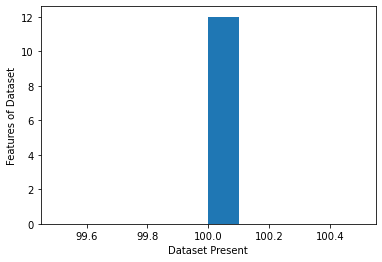


Pairwise correlation of all columns in the dataframe




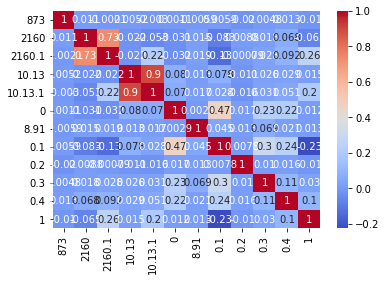

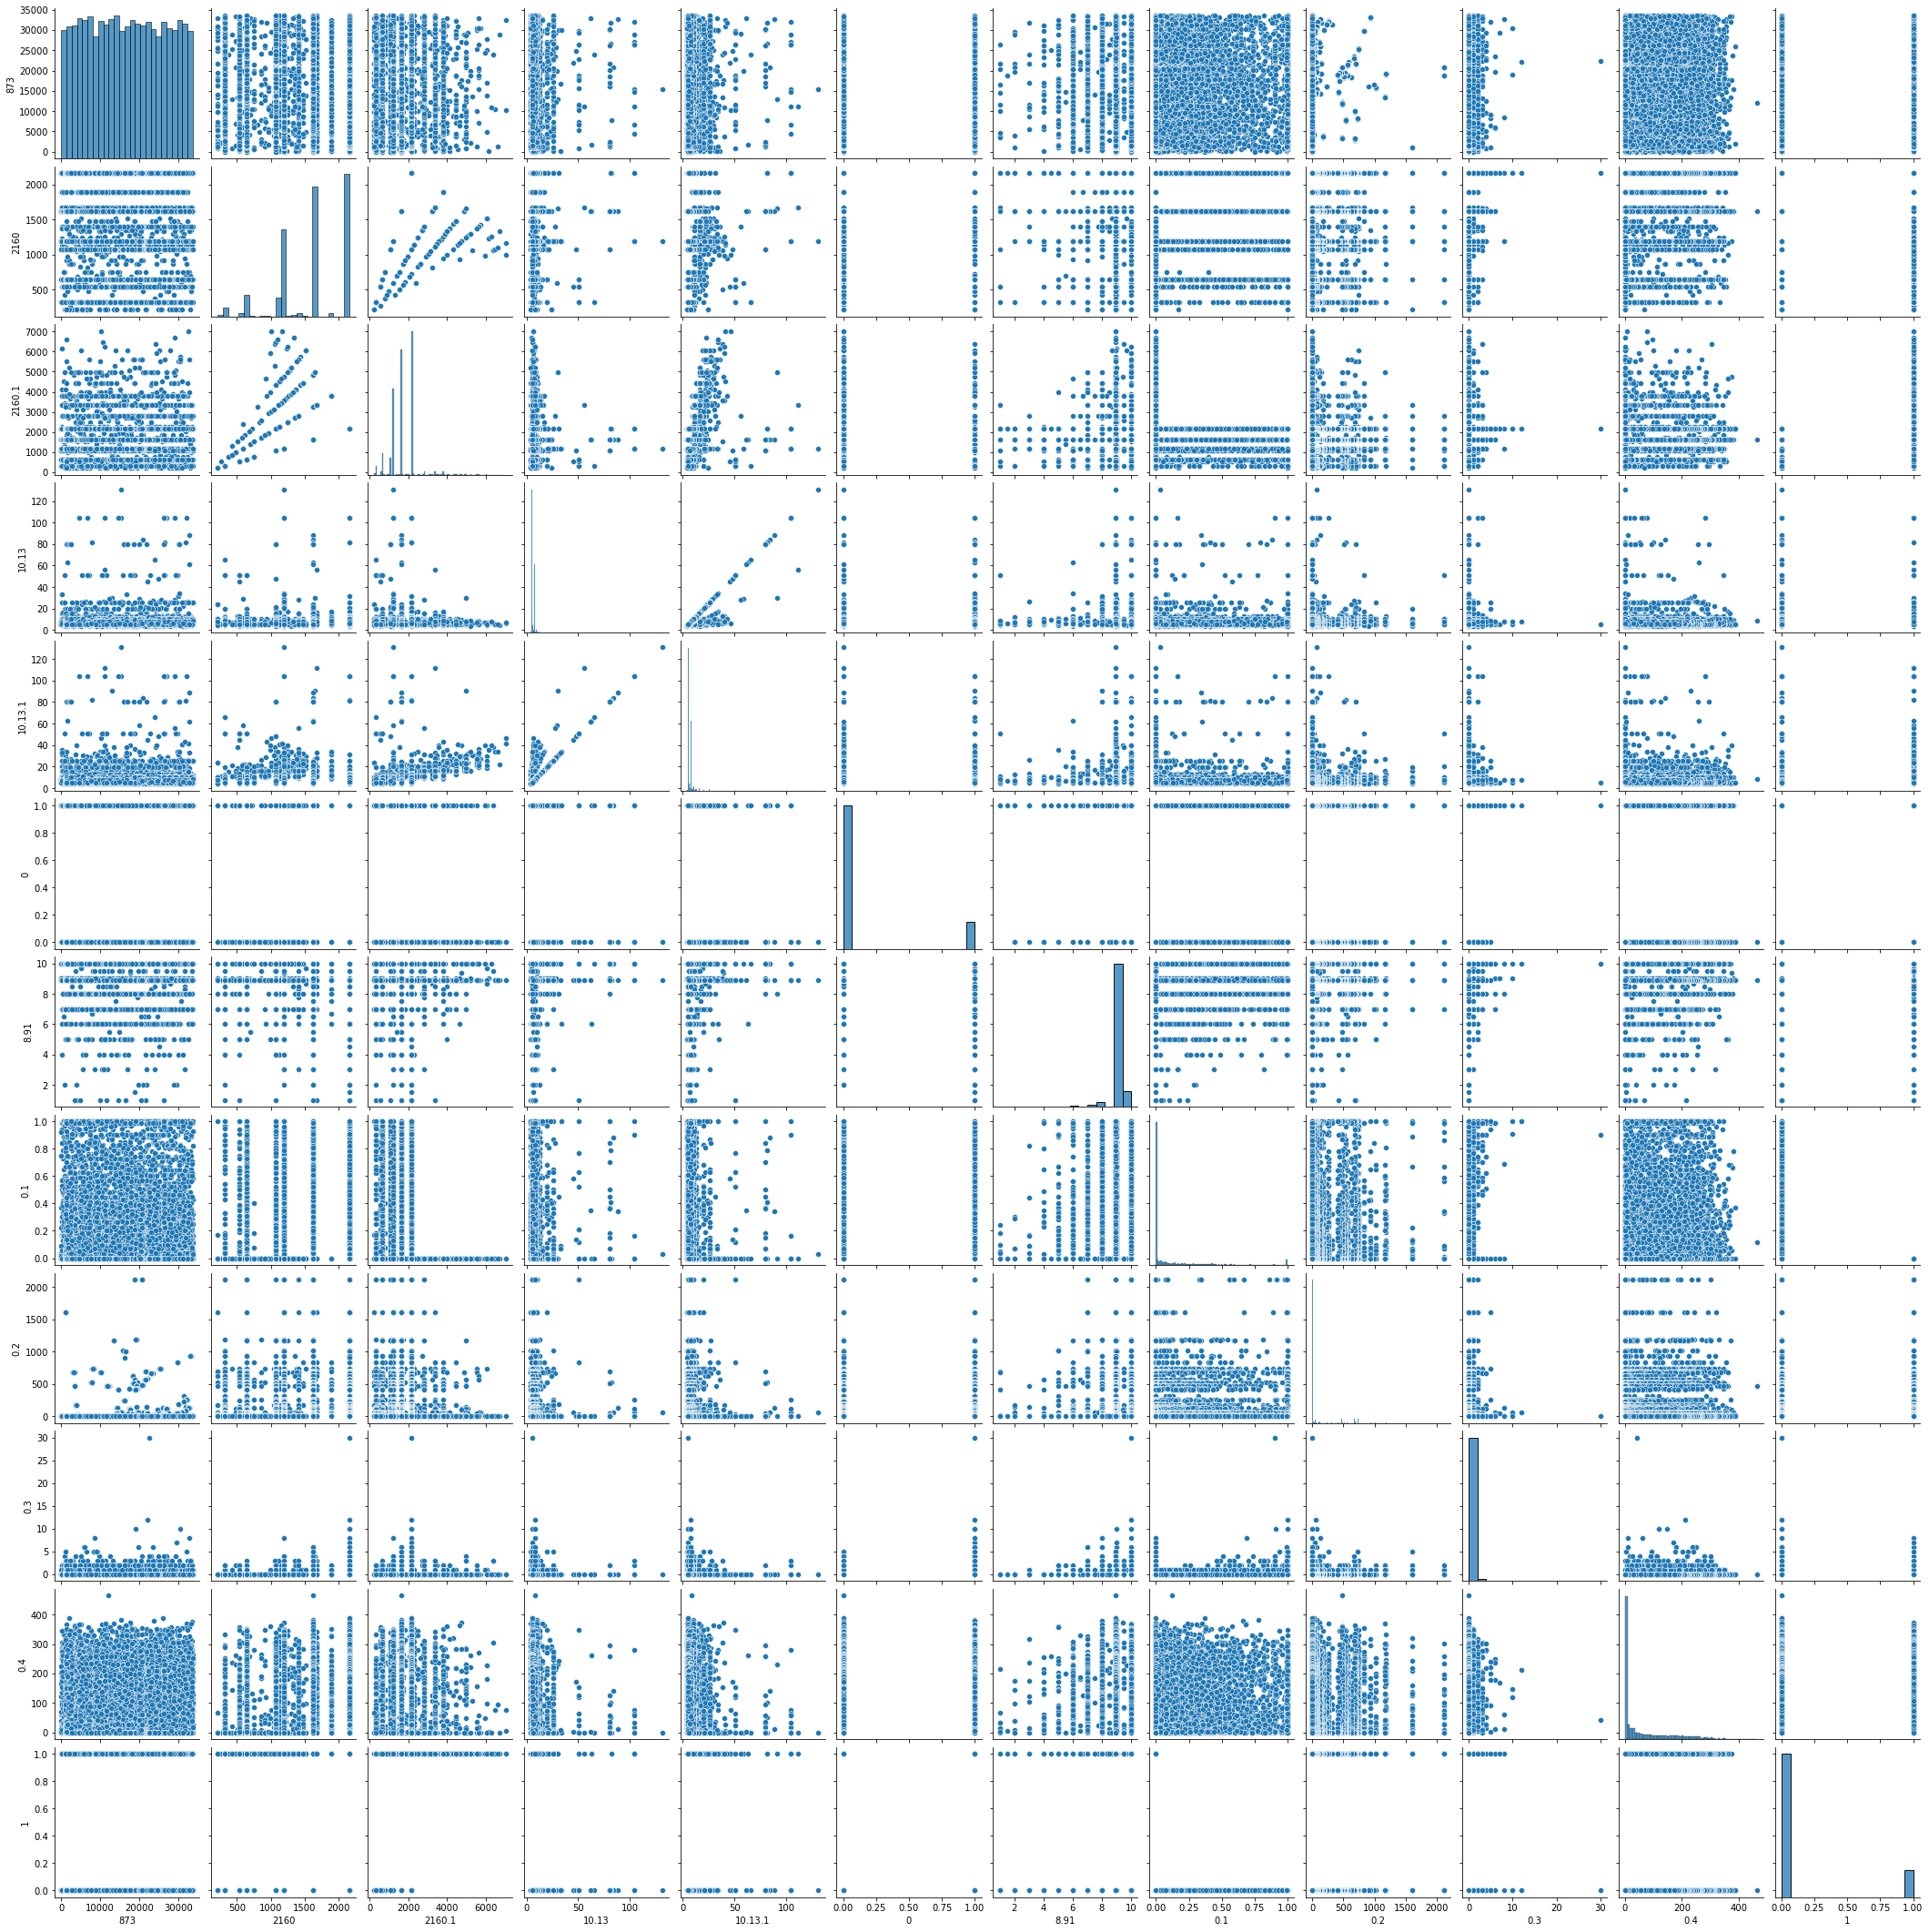

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
print("Shape of Dataset")
print(df.shape)
print()
print("unique elements in Features")
print()
print(df.nunique())
print()
print("duplicated Series values")
print(df.duplicated().sum())
print()
print("About Features : ")
print()
print(df.count()/df.isna().count()*100)
x=df.count()/df.isna().count()*100
plt.hist(x)
plt.ylabel("Features of Dataset")
plt.xlabel("Dataset Present")
plt.show()
#or we can use df.info() to get basic info about data 
print()
print('\033[1m'+"Pairwise correlation of all columns in the dataframe")
print()
df.corr()
print()
sns.heatmap(df.corr(),annot=True,cmap="coolwarm")
sns.pairplot(df)
